## **Урок 3. TensorFlow**
Попробуйте улучшить работу нейронной сети (разобранную на уроке), обучавшейся на датасет Fashion-MNIST. Напишите в комментариях к уроку, какого результата вы добились от нейросети и что помогло улучшить её точность


In [1]:
import keras
from keras.layers import *
import keras.utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import load_model
import tensorflow as tf

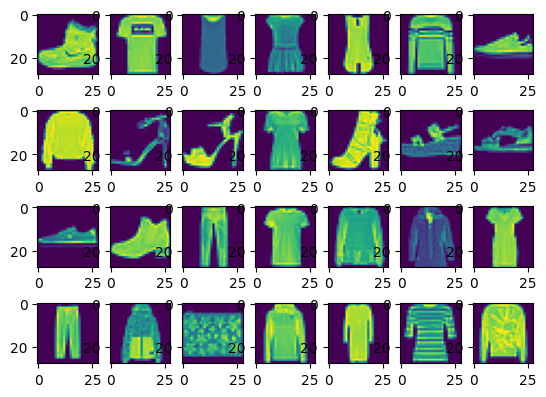

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

for i in range(28):
    plt.subplot(4,7,i+1)
    plt.imshow(x_train[i])
plt.show()

In [3]:
input_shape = (28, 28, 1)
x_train = x_train / 255
x_test = x_test / 255
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

Посмотрим, как изменится точность модели, если изменить количество батчей. Пусть количество батчей будет: 32 и 64.

In [4]:
def create_model(): # Функция для создания модели
  model = keras.Sequential([
    keras.Input(shape=input_shape),
    Conv2D(32, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
    MaxPooling2D( (2,2), strides = 2),
    Flatten(), # перевод в одномерный массив
    Dense(50, activation = 'relu'), # количество входных нейронов
    Dense(10, activation = 'softmax')   # количество выходных нейронов
    ] )

  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [5]:
%%time
# создадим список батчей
batch_size_list = [32, 64]
# пустой словарик для записи результатов
res_model = {}

# пройдемся циклом по каждому элементу списка батчей
for el in batch_size_list:

    model_el = create_model()
    # Перед обучением добавим защиту от переобучения
    # если в течении 3 эпох точность не будет расти, то обучение прервется
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    # обучаем модель на 12 эпохах, предварительные результаты не выводим, только конечный
    history = model_el.fit(x_train, y_train_cat, batch_size=el, epochs=12, validation_data =(x_test, y_test_cat), verbose=0, callbacks=[es_callback] )
    # добавляем сообщение, когда закончилось обучение
    if es_callback.stopped_epoch >=1:
        print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
    # оценим работу модели на тестовых данных
    test_loss, test_acc = model_el.evaluate(x_test, y_test_cat, verbose=2)
    # резбльтат модели выведем на экран
    print(f'Точность модели model_{el}: {100*test_acc:.2f} %')
    # сохраняем в словарь результаты конкретной модели (для построения диаграммы)
    res_model[f'model_{el}'] = history

313/313 - 2s - loss: 0.2952 - accuracy: 0.9169 - 2s/epoch - 7ms/step
Точность модели model_32: 91.69 %
Обучение остановлено на 11 эпохе
313/313 - 2s - loss: 0.2830 - accuracy: 0.9122 - 2s/epoch - 5ms/step
Точность модели model_64: 91.22 %
CPU times: user 17min 58s, sys: 21.7 s, total: 18min 20s
Wall time: 12min 53s


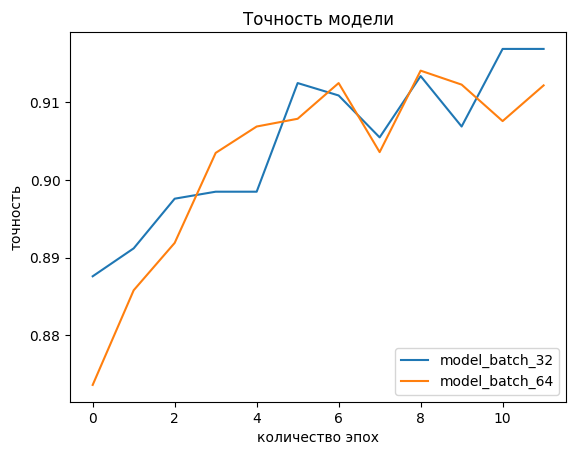

In [6]:
plt.plot(res_model['model_32'].history['val_accuracy'])
plt.plot(res_model['model_64'].history['val_accuracy'])
# название диаграммы
plt.title('Точность модели')
# ось y
plt.ylabel('точность')
# ось x
plt.xlabel('количество эпох')
# подпись графиков
plt.legend(['model_batch_32', 'model_batch_64', ], loc='lower right')
plt.show()

**Результат:** в данном случае увеличение количества батчей в 2 раза не увеличило точность. Данные взяты для 12 эпох. Обучение остановлено на 11 эпохе.

Попробуем изменить точность модели, увеличив **количество сверточных слоёв**. Наибольшая точность модели с 1 сверточным равна 91,6 %.
Протестируем модели с 2 и 3 сверточными слоями. Количество эпох возьмем 15.

In [7]:
# Создадим модель с двумя слоями
model_2 = keras.Sequential([
      keras.Input(shape=input_shape),
      Conv2D(32, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Conv2D(64, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Flatten(), # перевод в одномерный массив
      Dense(50,activation = 'relu'), # количество входных нейронов
      Dense(10, activation = 'softmax')   # количество выходных нейронов
      ] )

model_2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [8]:
%%time

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history_2 = model_2.fit(x_train, y_train_cat, batch_size=32, epochs=15, validation_data =(x_test, y_test_cat), verbose=1, callbacks=[es_callback] )
if es_callback.stopped_epoch >=1:
    print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
test_loss, test_acc = model_2.evaluate(x_test, y_test_cat, verbose=2)
print(f'Точность модели model_2: {100*test_acc:.2f} %')
res_model[f'model_2'] = history_2

Epoch 1/15
1875/1875 [==============================] - 73s 38ms/step - loss: 0.4268 - accuracy: 0.8476 - val_loss: 0.3722 - val_accuracy: 0.8670
Epoch 2/15
1875/1875 [==============================] - 68s 36ms/step - loss: 0.2799 - accuracy: 0.8990 - val_loss: 0.2778 - val_accuracy: 0.8999
Epoch 3/15
1875/1875 [==============================] - 69s 37ms/step - loss: 0.2332 - accuracy: 0.9151 - val_loss: 0.3095 - val_accuracy: 0.8929
Epoch 4/15
1875/1875 [==============================] - 68s 36ms/step - loss: 0.2045 - accuracy: 0.9234 - val_loss: 0.2584 - val_accuracy: 0.9072
Epoch 5/15
1875/1875 [==============================] - 70s 37ms/step - loss: 0.1806 - accuracy: 0.9334 - val_loss: 0.2318 - val_accuracy: 0.9175
Epoch 6/15
1875/1875 [==============================] - 68s 36ms/step - loss: 0.1590 - accuracy: 0.9406 - val_loss: 0.2419 - val_accuracy: 0.9173
Epoch 7/15
1875/1875 [==============================] - 68s 36ms/step - loss: 0.1412 - accuracy: 0.9473 - val_loss: 0.2318 -

In [9]:
# Создадим модель с тремя слоями
model_3 = keras.Sequential([
      keras.Input(shape=input_shape),
      Conv2D(32, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Conv2D(64, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Conv2D(128, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Flatten(), # перевод в одномерный массив
      Dense(50,activation = 'relu'), # количество входных нейронов
      Dense(10, activation = 'softmax')   # количество выходных нейронов
      ] )

model_3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [10]:
%%time

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history_3 = model_3.fit(x_train, y_train_cat, batch_size=32, epochs=15, validation_data =(x_test, y_test_cat), verbose=1, callbacks=[es_callback] )
if es_callback.stopped_epoch >=1:
    print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
test_loss, test_acc = model_3.evaluate(x_test, y_test_cat, verbose=2)
print(f'Точность модели model_3: {100*test_acc:.2f} %')
res_model[f'model_3'] = history_3

Epoch 1/15
1875/1875 [==============================] - 97s 51ms/step - loss: 0.4522 - accuracy: 0.8356 - val_loss: 0.3283 - val_accuracy: 0.8822
Epoch 2/15
1875/1875 [==============================] - 94s 50ms/step - loss: 0.2868 - accuracy: 0.8954 - val_loss: 0.3129 - val_accuracy: 0.8906
Epoch 3/15
1875/1875 [==============================] - 94s 50ms/step - loss: 0.2431 - accuracy: 0.9114 - val_loss: 0.2576 - val_accuracy: 0.9076
Epoch 4/15
1875/1875 [==============================] - 91s 49ms/step - loss: 0.2114 - accuracy: 0.9221 - val_loss: 0.2609 - val_accuracy: 0.9051
Epoch 5/15
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1860 - accuracy: 0.9316 - val_loss: 0.2629 - val_accuracy: 0.9046
Epoch 6/15
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1656 - accuracy: 0.9401 - val_loss: 0.2584 - val_accuracy: 0.9114
Epoch 7/15
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1478 - accuracy: 0.9452 - val_loss: 0.2502 -

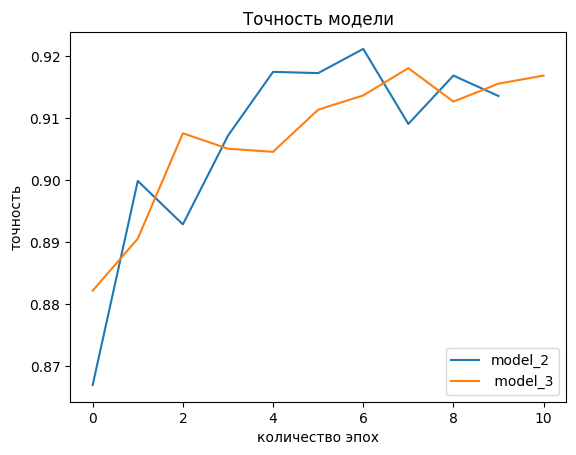

In [15]:

plt.plot(res_model['model_2'].history['val_accuracy'])
plt.plot(res_model['model_3'].history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['model_2', ' model_3'], loc='lower right')
plt.show()

**В результате,** мы улучшили работу нейронной сети, увеличив точность до 91.69 % с тремя свёрточными слоями.